Load in the raster with percent dead cover (roi) and the raster of landsat imagery (img). For this purpose, the size of landsat would be too big, so this raster is all na's except in places where it overlaps with the roi file (see GEE script for how this was accomplished. In addition, these are being loaded as numpy arrays due to size constraints, the conversion from raster to array is done in a corresponding notebook

In [ ]:
from mmap import mmap
import numpy as np
img = np.load('',mmap_mode='r')
roi = np.load('',mmap_mode='r')

Quick check of size of training data

In [ ]:
n_samples = (roi > 0 ).sum()
print('We have {n} samples'.format(n=n_samples))

So now lets label our data as x and y, y contains the 'labeled' data and x contains the spectral data

In [ ]:
x = img[roi > 0, :]

y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=x.shape))
print('Our Y array is sized: {sz}'.format(sz=y.shape))

Our X matrix is sized: (1503, 6)
Our Y array is sized: (1503,)


I converted the spectral data to a dataframe briefly so that I could add additional indices to the data for improved predictive power. Each indice is just a linear combination of original spectral bands from landsat

In [ ]:
import pandas as pd
X = pd.DataFrame(x)

In [ ]:
X['NDVI'] = (X.iloc[:,4] - X.iloc[:,3])/(X.iloc[:,4] + X.iloc[:,3])
X['NDI'] = (X.iloc[:,2] - X.iloc[:,3])/(X.iloc[:,2] + X.iloc[:,3])
X['EGI'] = 2*(X.iloc[:,2]) + (X.iloc[:,1]) + (X.iloc[:,3])
X["NCI"] = (X.iloc[:,1] - X.iloc[:,2])/(X.iloc[:,1] + X.iloc[:,2])
X["VARI"] = (X.iloc[:,2] - X.iloc[:,3])/(X.iloc[:,3] + X.iloc[:,2] + X.iloc[:,1])

The data then needs to be converted back to numpy array

In [ ]:
x = np.array(X)

# Kernel Ridge Regression

I first tested out kernel ridge regression for this project. This code used KRR to predict cover of dead sagebrush and reports the accuracy.

I used grive seach in sklearn to first find the ideal hyperparameters for KRR

In [ ]:
from sklearn.model_selection import GridSearchCV
import time
kr = GridSearchCV(
    KernelRidge(kernel="linear"),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3]},
)
t0 = time.time()
kr.fit(train_X, train_y)
kr_fit = time.time() - t0
print(f"Best KRR with params: {kr.best_params_} and R2 score: {kr.best_score_:.3f}")
print("KRR complexity and bandwidth selected and model fitted in %.3f s" % kr_fit)

t0 = time.time()
y_kr = kr.predict(train_X)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s" % (train_X.shape[0], kr_predict)
y_pred

Best KRR with params: {'alpha': 1.0} and R2 score: 0.165
KRR complexity and bandwidth selected and model fitted in 1.524 s
KRR prediction for 1202 inputs in 0.023 s


In [ ]:
from sklearn.kernel_ridge import KernelRidge
import pickle
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(x, y, test_size = 0.1)

def accuracy(model, data_X, data_y, pct_close):
  # correct within pct of true income
  n_correct = 0; n_wrong = 0

  for i in range(len(data_X)):
    X = data_X[i].reshape(1, -1)  # one-item batch
    y = data_y[i]
    pred = model.predict(X)       # predicted income

    if np.abs(pred - y) < np.abs(pct_close * y):
      n_correct += 1
    else:
      n_wrong += 1
  acc = (n_correct * 1.0) / (n_correct + n_wrong)
  return acc



np.random.seed(1)

model = KernelRidge(alpha=0.1, kernel='polynomial',gamma=0.01)
model = model.fit(train_X, train_y)

print("\nComputing accuracy (within 0.10 of true) ")
acc_train = accuracy(model, train_X, train_y, 0.10)
print("Accuracy on train data = %0.4f " % acc_train)
acc_test = accuracy(model, test_X, test_y, 0.10)
print("Accuracy on test data = %0.4f " % acc_test)
y_pred = model.predict(test_X)


Computing accuracy (within 0.10 of true) 
Accuracy on train data = 0.0556 
Accuracy on test data = 0.0000 


This code then plots the training vs test data relative to observed values

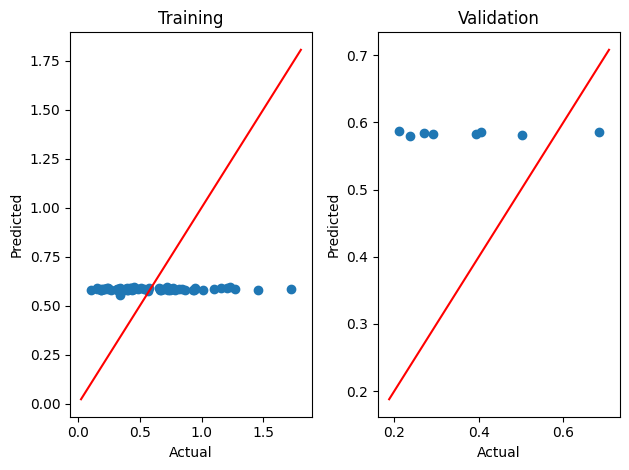

In [ ]:
import matplotlib.pyplot as plt
# scatterplot of actual vs. pred
# specify the dimensions
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=train_y, y=model.predict(train_X)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x1 = np.linspace(*axes[0].get_xlim())
axes[0].plot(x1, x1, color='red')
# Validation Results
axes[1].scatter(x=test_y, y=model.predict(test_X)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x1 = np.linspace(*axes[1].get_xlim())
axes[1].plot(x1, x1, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

# Linear Regression

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#train_x,test_x,train_y,test_y = train_test_split(x, y, test_size = 0.05)

model = LinearRegression().fit(test_y.reshape(-1,1),y_pred)
r_sq = model.score(test_y.reshape(-1,1), y_pred)
print(r_sq)
#pred_y = model.predict(test_x)
#mse = np.mean(np.square(test_y-pred_y))

#print(mse)
#print(mse**.5)

0.051513524809759015


# Convolutional Neural Network

This code works through building and training a CNN for this data. The results clearly showed that the size of the training data was too small but the code is still valuable

In [ ]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x, y, test_size = 0.15)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import keras
min_max_scaler = MinMaxScaler()
train_x = min_max_scaler.fit_transform(train_x)
test_x = min_max_scaler.fit_transform(test_x)

# build the model!
model = Sequential()
model.add(Dense(16, input_shape=(train_x.shape[1],), activation='leaky_relu')) # (features,)
model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(16, activation='leaky_relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like
optimizer = keras.optimizers.Adam(lr=0.1)
# compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(train_x, train_y,
                    validation_data = (test_x, test_y),
                    callbacks=[es],
                    epochs=5000,
                    batch_size=50,
                    verbose=1)

NameError: name 'train_x' is not defined

Plot training and validation loss

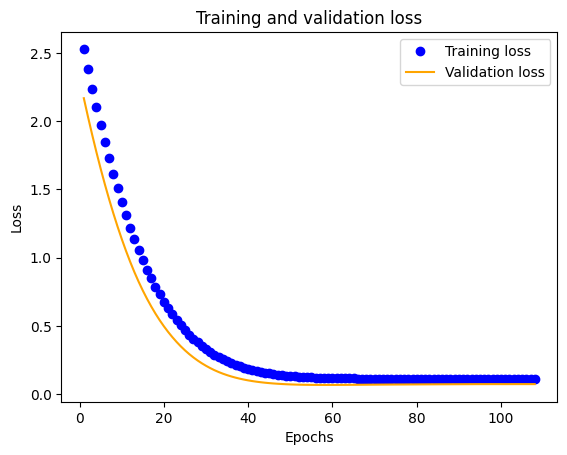

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot training and test values vs observed values

1/1 [==============================] - 0s 22ms/step


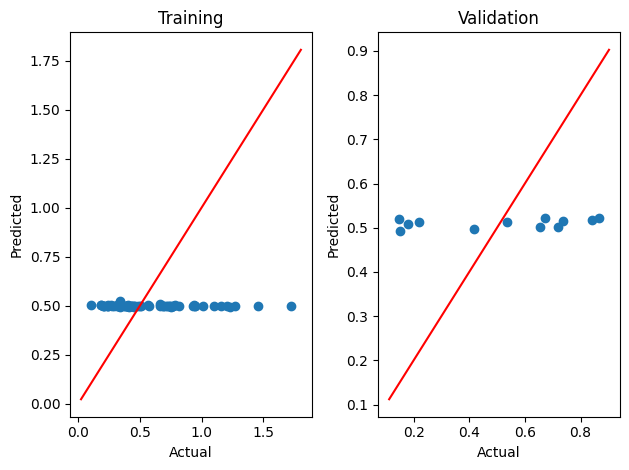

In [ ]:

# scatterplot of actual vs. pred
# specify the dimensions
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=train_y, y=model.predict(train_x)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x1 = np.linspace(*axes[0].get_xlim())
axes[0].plot(x1, x1, color='red')
# Validation Results
axes[1].scatter(x=test_y, y=model.predict(test_x)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x1 = np.linspace(*axes[1].get_xlim())
axes[1].plot(x1, x1, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

# Random Forest Ensemble

I first used the grid seach to find the best hyperparameters for a random forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import ensemble

## Define Grid
param_grid = {
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}

# print classification report
## show start time
#print(datetime.now())
## Grid Search function
grid = GridSearchCV(estimator=ensemble.RandomForestRegressor(), param_grid=param_grid, cv= 5)
grid.fit(train_x, train_y)

grid_predictions = grid.predict(test_x)


The code below fits an RF and reports variable importance

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn import ensemble

train_x,test_x,train_y,test_y = train_test_split(x, y, test_size = 0.50)
dtr = ensemble.RandomForestRegressor(n_estimators = 100,max_features=3,max_depth=10,n_jobs=-1)
regr = dtr.fit(train_x, train_y)
pred_y = regr.predict(test_x)
mse = np.mean(np.square(test_y-pred_y))

print(mse)
print(mse**.5)
variables = list(range(0,x.shape[1]))
for b, imp in zip(variables, regr.feature_importances_):
  print('Variable {b} importance: {imp}'.format(b=b, imp=imp))

0.10378265896427137
0.322153160723702
Variable 0 importance: 0.18930939517290304
Variable 1 importance: 0.18413359318269562
Variable 2 importance: 0.2150313726868334
Variable 3 importance: 0.1698563826535528
Variable 4 importance: 0.2416692563040152


Test and training data vs observed

In [ ]:
import matplotlib.pyplot as plt
# scatterplot of actual vs. pred
# specify the dimensions
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=train_y, y=regr.predict(train_x)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x1 = np.linspace(*axes[0].get_xlim())
axes[0].plot(x1, x1, color='red')
# Validation Results
axes[1].scatter(x=test_y, y=regr.predict(test_x)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x1 = np.linspace(*axes[1].get_xlim())
axes[1].plot(x1, x1, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

This model ultimately worked the best, I used 'joblib' to save the trained RF model for use in a different script

In [ ]:
import joblib

# save
joblib.dump(regr, "")

['/content/drive/MyDrive/Drone_Flights/RF_intermediate/Nov6_regressor.joblib']